In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import os

/Users/utoglu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/utoglu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

False
None


In [3]:
file_path = 'datasets/DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.1]  
print("Filtered dataset size:", len(df))

extra_path = 'datasets/dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}

    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None

    chrom_col = pick(["chromophore", "smiles"])
    solv_col  = pick(["solvent"])
    qy_col    = pick(["quantum yield", "plqy", "plq y", "qy"])

    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna()
                            & df_extra["Chromophore"].notna()
                            & df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.1]
        print("Extra dataset usable rows:", len(df_extra))


        df = pd.concat([df, df_extra], ignore_index=True)
    else:
        print("dataset2.xlsx found but required columns (SMILES/chromophore, solvent, PLQY/Quantum yield) not detected; using only base CSV.")
else:
    print("Extra dataset 'dataset2.xlsx' not found; using only base CSV.")

print("Total combined filtered dataset size:", len(df))
df.head()

Filtered dataset size: 9519
Extra dataset usable rows: 2188
Total combined filtered dataset size: 11707


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.95
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.00
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.20
3,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,CO,0.60
4,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,CCO,0.69


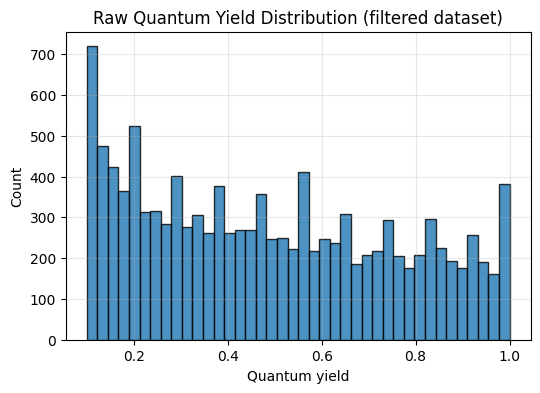

In [4]:
plt.figure(figsize=(6,4))
plt.hist(df["Quantum yield"], bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield")
plt.ylabel("Count")
plt.title("Raw Quantum Yield Distribution (filtered dataset)")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [6]:
import torch

CACHE_FILE = "embedding caches/embedding_cache_qy_0.1.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [7]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [8]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([11707, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([11707, 768])
Combined embedding shape: torch.Size([11707, 1536])


In [9]:
combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

print("Raw combined embedding shape:", combined_emb.shape)
print("Target shape:", y.shape)

Raw combined embedding shape: torch.Size([11707, 1536])
Target shape: torch.Size([11707, 1])


In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

if 'combined_emb' in globals():
    X = combined_emb.numpy() if hasattr(combined_emb, 'numpy') else np.array(combined_emb)
else:
    raise RuntimeError('combined_emb not found. Run the embedding cells first.')

if 'y' in globals():
    if hasattr(y, 'numpy'):
        y_np = y.squeeze(1).numpy()
    else:
        y_np = np.array(y).squeeze()
else:
    raise RuntimeError('y (targets) not found. Run earlier cells that set y.')


X_train, X_temp, y_train, y_temp = train_test_split(X, y_np, test_size=0.30, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print(f"X shape: {X.shape}, y shape: {y_np.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X shape: (11707, 1536), y shape: (11707,)
X_train: (8194, 1536), y_train: (8194,)
X_val: (2342, 1536), y_val: (2342,)
X_test: (1171, 1536), y_test: (1171,)


In [11]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

n_chrom_features = chrom_emb.shape[1]  
n_solv_features = solv_emb.shape[1]    

X_train_chrom = X_train[:, :n_chrom_features]
X_train_solv = X_train[:, n_chrom_features:]
X_val_chrom = X_val[:, :n_chrom_features]
X_val_solv = X_val[:, n_chrom_features:]
X_test_chrom = X_test[:, :n_chrom_features]
X_test_solv = X_test[:, n_chrom_features:]

scaler_chrom = StandardScaler()
scaler_solv = StandardScaler()

X_train_chrom_scaled = scaler_chrom.fit_transform(X_train_chrom)
X_train_solv_scaled = scaler_solv.fit_transform(X_train_solv)

X_val_chrom_scaled = scaler_chrom.transform(X_val_chrom)
X_val_solv_scaled = scaler_solv.transform(X_val_solv)
X_test_chrom_scaled = scaler_chrom.transform(X_test_chrom)
X_test_solv_scaled = scaler_solv.transform(X_test_solv)

X_train_scaled = np.concatenate([X_train_chrom_scaled, X_train_solv_scaled], axis=1)
X_val_scaled = np.concatenate([X_val_chrom_scaled, X_val_solv_scaled], axis=1)
X_test_scaled = np.concatenate([X_test_chrom_scaled, X_test_solv_scaled], axis=1)

X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

print("✓ Scaled embeddings using training data statistics only (no data leakage)")
print(f"X_train scaled: {X_train.shape}, mean: {X_train.mean():.6f}, std: {X_train.std():.6f}")
print(f"X_val scaled: {X_val.shape}, mean: {X_val.mean():.6f}, std: {X_val.std():.6f}")
print(f"X_test scaled: {X_test.shape}, mean: {X_test.mean():.6f}, std: {X_test.std():.6f}")


✓ Scaled embeddings using training data statistics only (no data leakage)
X_train scaled: (8194, 1536), mean: -0.000000, std: 0.999999
X_val scaled: (2342, 1536), mean: -0.000057, std: 1.000045
X_test scaled: (1171, 1536), mean: 0.000017, std: 0.997793


In [12]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_lambda=2.0,
    reg_alpha=0.2,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    tree_method="hist"
)

eval_set = [(X_train, y_train), (X_val, y_val)]


xgb_model.fit(
    X_train, y_train, 
    eval_set=eval_set, 
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)
print(f"Test Set - R Squared: {r2_score(y_test, y_pred_xgb):.3f}")
print(f"Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")

Test Set - R Squared: 0.512
Test Set - RMSE: 0.192


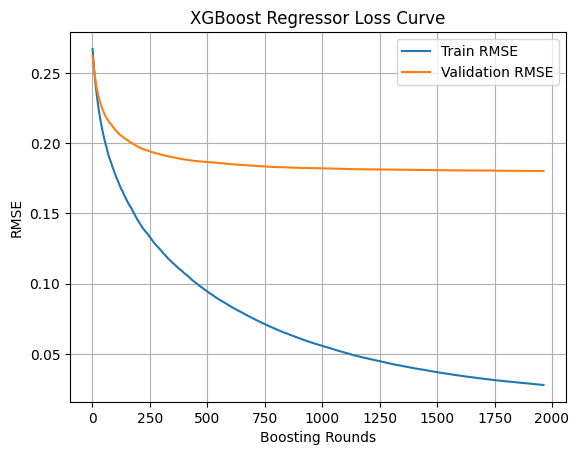

In [13]:
import matplotlib.pyplot as plt

results = xgb_model.evals_result()
epochs = range(1, len(results['validation_0']['rmse']) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, results['validation_0']['rmse'], label='Train RMSE')
ax.plot(epochs, results['validation_1']['rmse'], label='Validation RMSE')
ax.legend()

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Regressor Loss Curve')
plt.grid(True)
plt.show()

In [14]:

from xgboost import XGBRegressor


xgb_model_improved = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02, 
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,  
    min_child_weight=8, 
    reg_lambda=5.0, 
    reg_alpha=1.0,
    gamma=0.1, 
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    tree_method="hist"
)


eval_set = [(X_train, y_train), (X_val, y_val)]

xgb_model_improved.fit(
    X_train, y_train, 
    eval_set=eval_set, 
    verbose=False
)

y_pred_xgb_improved = xgb_model_improved.predict(X_test)
print(f"Improved XGBoost Test Set - R Squared: {r2_score(y_test, y_pred_xgb_improved):.3f}")
print(f"Improved XGBoost Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb_improved)):.3f}")


y_train_pred_xgb_improved = xgb_model_improved.predict(X_train)
print(f"\nTrain R²: {r2_score(y_train, y_train_pred_xgb_improved):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred_xgb_improved):.4f}")
print(f"Overfitting gap: {r2_score(y_train, y_train_pred_xgb_improved) - r2_score(y_test, y_pred_xgb_improved):.4f}")


Improved XGBoost Test Set - R Squared: 0.441
Improved XGBoost Test Set - RMSE: 0.206

Train R²: 0.6992
Test R²:  0.4410
Overfitting gap: 0.2582


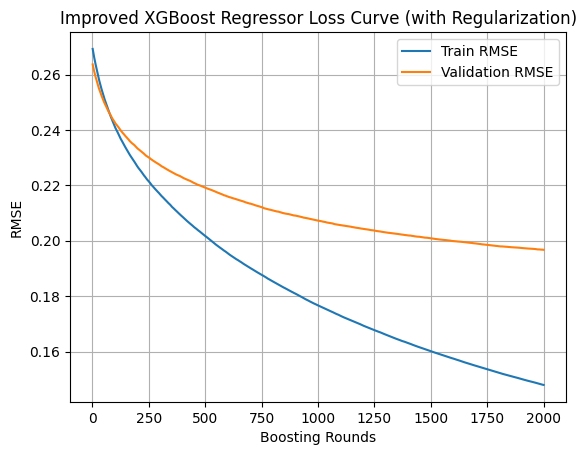

In [15]:
import matplotlib.pyplot as plt

results_improved = xgb_model_improved.evals_result()
epochs_improved = range(1, len(results_improved['validation_0']['rmse']) + 1)

fig, ax = plt.subplots()
ax.plot(epochs_improved, results_improved['validation_0']['rmse'], label='Train RMSE')
ax.plot(epochs_improved, results_improved['validation_1']['rmse'], label='Validation RMSE')
ax.legend()

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Improved XGBoost Regressor Loss Curve (with Regularization)')
plt.grid(True)
plt.show()


LIGHTGBM

In [16]:
import lightgbm as lgb

lgb_model_improved = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02, 
    num_leaves=15, 
    max_depth=3,  
    min_child_samples=20, 
    subsample=0.7,  
    colsample_bytree=0.7,  
    reg_alpha=1.0,
    reg_lambda=5.0,  
    min_split_gain=0.1,  
    random_state=42
)


eval_set = [(X_train, y_train), (X_val, y_val)]

lgb_model_improved.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])


y_pred_lgb_improved = lgb_model_improved.predict(X_test)
print(f"Improved LightGBM Test R²: {r2_score(y_test, y_pred_lgb_improved):.4f}")
print(f"Improved LightGBM Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb_improved)):.4f}")


y_train_pred_improved = lgb_model_improved.predict(X_train)
print(f"\nTrain R²: {r2_score(y_train, y_train_pred_improved):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred_lgb_improved):.4f}")
print(f"Overfitting gap: {r2_score(y_train, y_train_pred_improved) - r2_score(y_test, y_pred_lgb_improved):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341570
[LightGBM] [Info] Number of data points in the train set: 8194, number of used features: 1536
[LightGBM] [Info] Start training from score 0.487895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [17]:
y_train_pred = xgb_model.predict(X_train)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test  R²:", r2_score(y_test, y_pred_xgb))

Train R²: 0.9886473417282104
Test  R²: 0.5121512413024902


In [18]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1, random_state=42)

eval_set = [(X_train, y_train), (X_val, y_val)]                                                                                                                             

lgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 341570
[LightGBM] [Info] Number of data points in the train set: 8194, number of used features: 1536
[LightGBM] [Info] Start training from score 0.487895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[988]	training's rmse: 0.0169619	training's l2: 0.000287705	valid_1's rmse: 0.181318	valid_1's l2: 0.0328764


LGBMRegressor(n_estimators=2000, random_state=42)

In [19]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred_lgb = lgb_model.predict(X_test)
print(f"Test Set - R Squared: {r2_score(y_test, y_pred_lgb):.3f}")
print(f"Test Set - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):.3f}")

Test Set - R Squared: 0.518
Test Set - RMSE: 0.191


In [20]:
y_train_pred_lgb = lgb_model.predict(X_train)

print("Train R²:", r2_score(y_train, y_train_pred_lgb))
print("Test  R²:", r2_score(y_test, y_pred_lgb))

Train R²: 0.9960467915101895
Test  R²: 0.5183025341847721


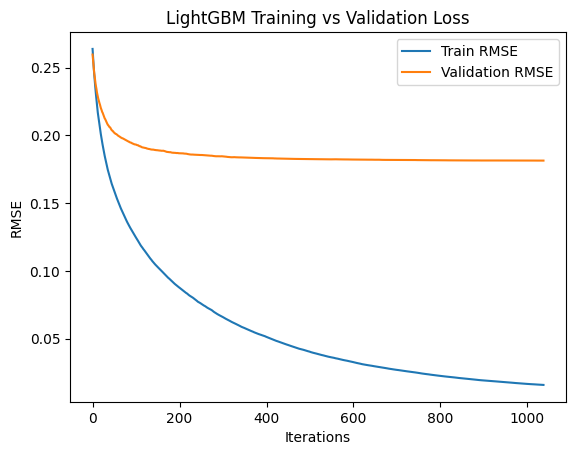

In [21]:
import matplotlib.pyplot as plt

results_lgb = lgb_model.evals_result_

train_rmse = results_lgb['training']['rmse']
val_rmse = results_lgb['valid_1']['rmse']

plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Validation Loss")
plt.legend()
plt.show()

In [22]:
print("\n" + "="*50)
print("=== LightGBM Validation Set Results ===")
print("="*50)

y_val_pred_lgb = lgb_model.predict(X_val)

y_val_true_lgb = np.ravel(y_val)
y_val_pred_lgb = np.ravel(y_val_pred_lgb)

r2_val_lgb  = r2_score(y_val_true_lgb, y_val_pred_lgb)
mae_val_lgb = mean_absolute_error(y_val_true_lgb, y_val_pred_lgb)
rmse_val_lgb = np.sqrt(mean_squared_error(y_val_true_lgb, y_val_pred_lgb))

print(f"Samples: {len(y_val_true_lgb)}")
print(f"R²   : {r2_val_lgb:.4f}")
print(f"MAE  : {mae_val_lgb:.4f}")
print(f"RMSE : {rmse_val_lgb:.4f}")

print("\n" + "="*50)
print("LightGBM: Train/Val/Test Comparison")
print("="*50)

y_train_pred_lgb = lgb_model.predict(X_train)
r2_train_lgb = r2_score(y_train, y_train_pred_lgb)
mae_train_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
rmse_train_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))

r2_test_lgb = r2_score(y_test, y_pred_lgb)
mae_test_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

comparison_df_lgb = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train), len(y_val_true_lgb), len(y_test)],
    "R²": [r2_train_lgb, r2_val_lgb, r2_test_lgb],
    "MAE": [mae_train_lgb, mae_val_lgb, mae_test_lgb],
    "RMSE": [rmse_train_lgb, rmse_val_lgb, rmse_test_lgb]
})
print(comparison_df_lgb.to_string(index=False))



=== LightGBM Validation Set Results ===
Samples: 2342
R²   : 0.5281
MAE  : 0.1349
RMSE : 0.1813

LightGBM: Train/Val/Test Comparison
       Set  Samples       R²      MAE     RMSE
     Train     8194 0.996047 0.009339 0.016962
Validation     2342 0.528093 0.134864 0.181318
      Test     1171 0.518303 0.144716 0.191085


=== XGBoost Test Set Results ===
Samples: 1171
R²   : 0.5122
MAE  : 0.1455
RMSE : 0.1923
Predictions saved to `models/xgb_predictions.csv`
Model saved to `models/xgb_res3.pkl`


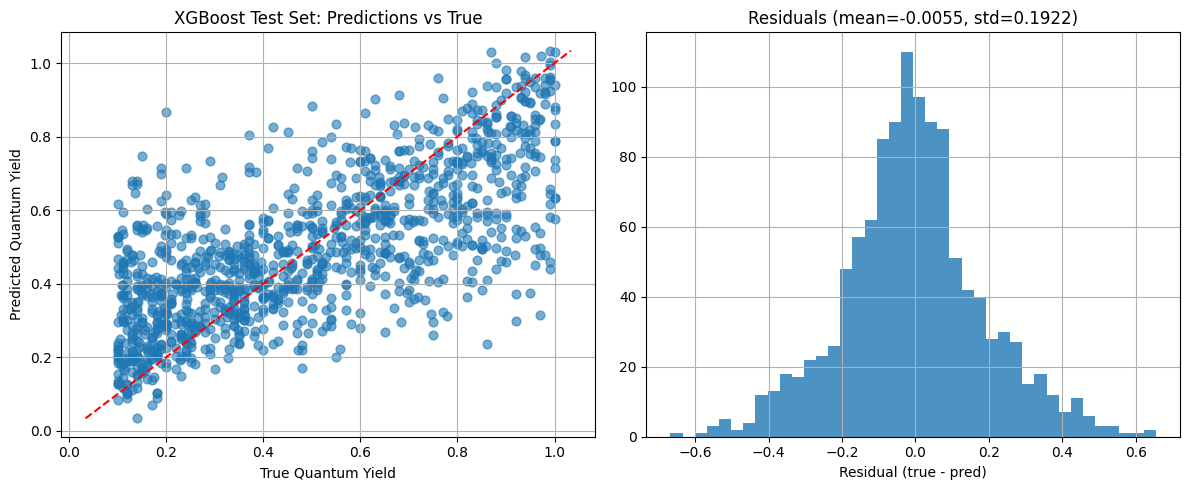

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import os


y_pred = xgb_model.predict(X_test)


y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)


r2  = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("=== XGBoost Test Set Results ===")
print(f"Samples: {len(y_true)}")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


os.makedirs("models", exist_ok=True)
pred_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
pred_df.to_csv("models/xgb_predictions.csv", index=False)
print("Predictions saved to `models/xgb_predictions.csv`")


joblib.dump(xgb_model, "models/xgb_res3.pkl")
print("Model saved to `models/xgb_res3.pkl`")


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_true, y_pred, alpha=0.6, s=40)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost Test Set: Predictions vs True")
plt.grid(True)

plt.subplot(1,2,2)
residuals = y_true - y_pred
plt.hist(residuals, bins=40, alpha=0.8)
plt.xlabel("Residual (true - pred)")
plt.title(f"Residuals (mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()

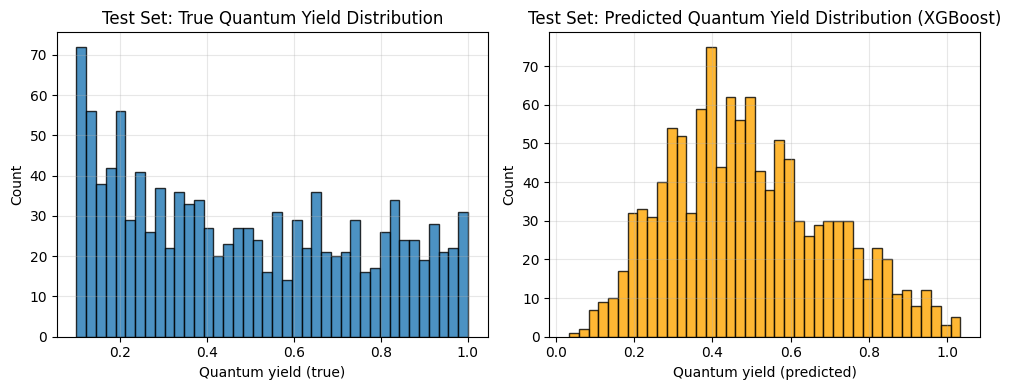

In [24]:

plt.figure(figsize=(10,4))


plt.subplot(1,2,1)
plt.hist(y_true, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)


plt.subplot(1,2,2)
plt.hist(y_pred, bins=40, alpha=0.8, edgecolor="black", color="orange")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (XGBoost)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


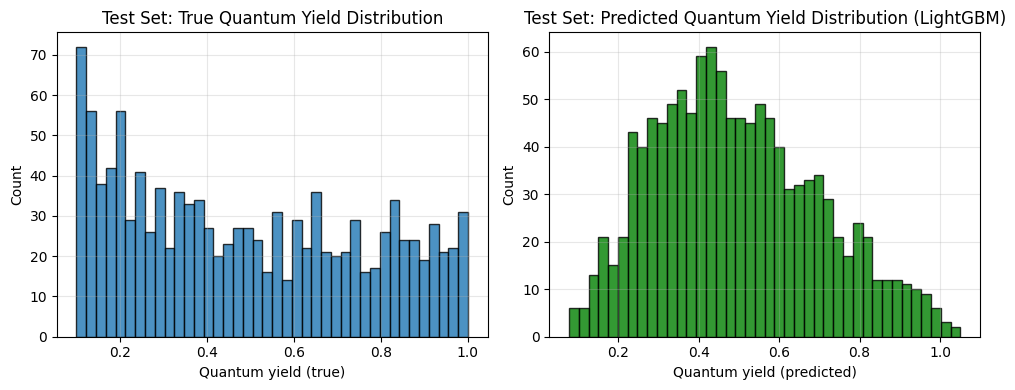

In [25]:
# Histograms of quantum yield after modeling (test set) - LightGBM
plt.figure(figsize=(10,4))

# True distribution on test set
plt.subplot(1,2,1)
plt.hist(y_test, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)

# Predicted distribution on test set (LightGBM)
plt.subplot(1,2,2)
plt.hist(y_pred_lgb, bins=40, alpha=0.8, edgecolor="black", color="green")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (LightGBM)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== XGBoost Validation Set Results ===
Samples: 2342
R²   : 0.5335
MAE  : 0.1345
RMSE : 0.1803


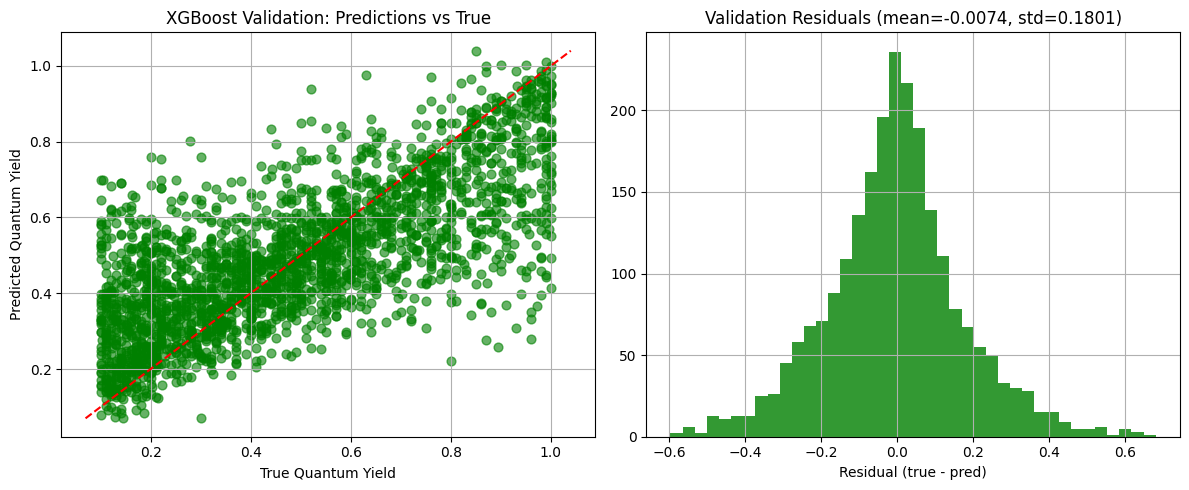


XGBoost: Train/Val/Test Comparison
       Set  Samples       R²      MAE     RMSE
     Train     8194 0.988647 0.019031 0.028744
Validation     2342 0.533468 0.134503 0.180283
      Test     1171 0.512151 0.145538 0.192301


In [26]:

print("\n" + "="*50)
print("=== XGBoost Validation Set Results ===")
print("="*50)

y_val_pred = xgb_model.predict(X_val)


y_val_true = np.ravel(y_val)
y_val_pred = np.ravel(y_val_pred)


r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='green')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("XGBoost Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='green')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


print("\n" + "="*50)
print("XGBoost: Train/Val/Test Comparison")
print("="*50)


y_train_pred = xgb_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train), len(y_val_true), len(y_true)],
    "R²": [r2_train, r2_val, r2],
    "MAE": [mae_train, mae_val, mae],
    "RMSE": [rmse_train, rmse_val, rmse]
})
print(comparison_df.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON

--------------------------------------------------------------------------------
ALL MODELS: COMPREHENSIVE METRICS COMPARISON
--------------------------------------------------------------------------------
              Model  Train R²   Val R²  Test R²  Train RMSE  Val RMSE  Test RMSE  Train MAE  Val MAE  Test MAE  Overfitting Gap
 XGBoost (Original)  0.988647 0.533468 0.512151    0.028744  0.180283   0.192301   0.019031 0.134503  0.145538         0.476496
 XGBoost (Improved)  0.699247 0.444407 0.441050    0.147946  0.196740   0.205838   0.117225 0.154772  0.163480         0.258198
LightGBM (Original)  0.996047 0.528093 0.518303    0.016962  0.181318   0.191085   0.009339 0.134864  0.144716         0.477744
LightGBM (Improved)  0.624619 0.404573 0.404183    0.165285  0.203670   0.212518   0.133224 0.163715  0.171845         0.220436

--------------------------------------------------------------------------------
TEST SET PERFORMANCE RANKING (Best to 

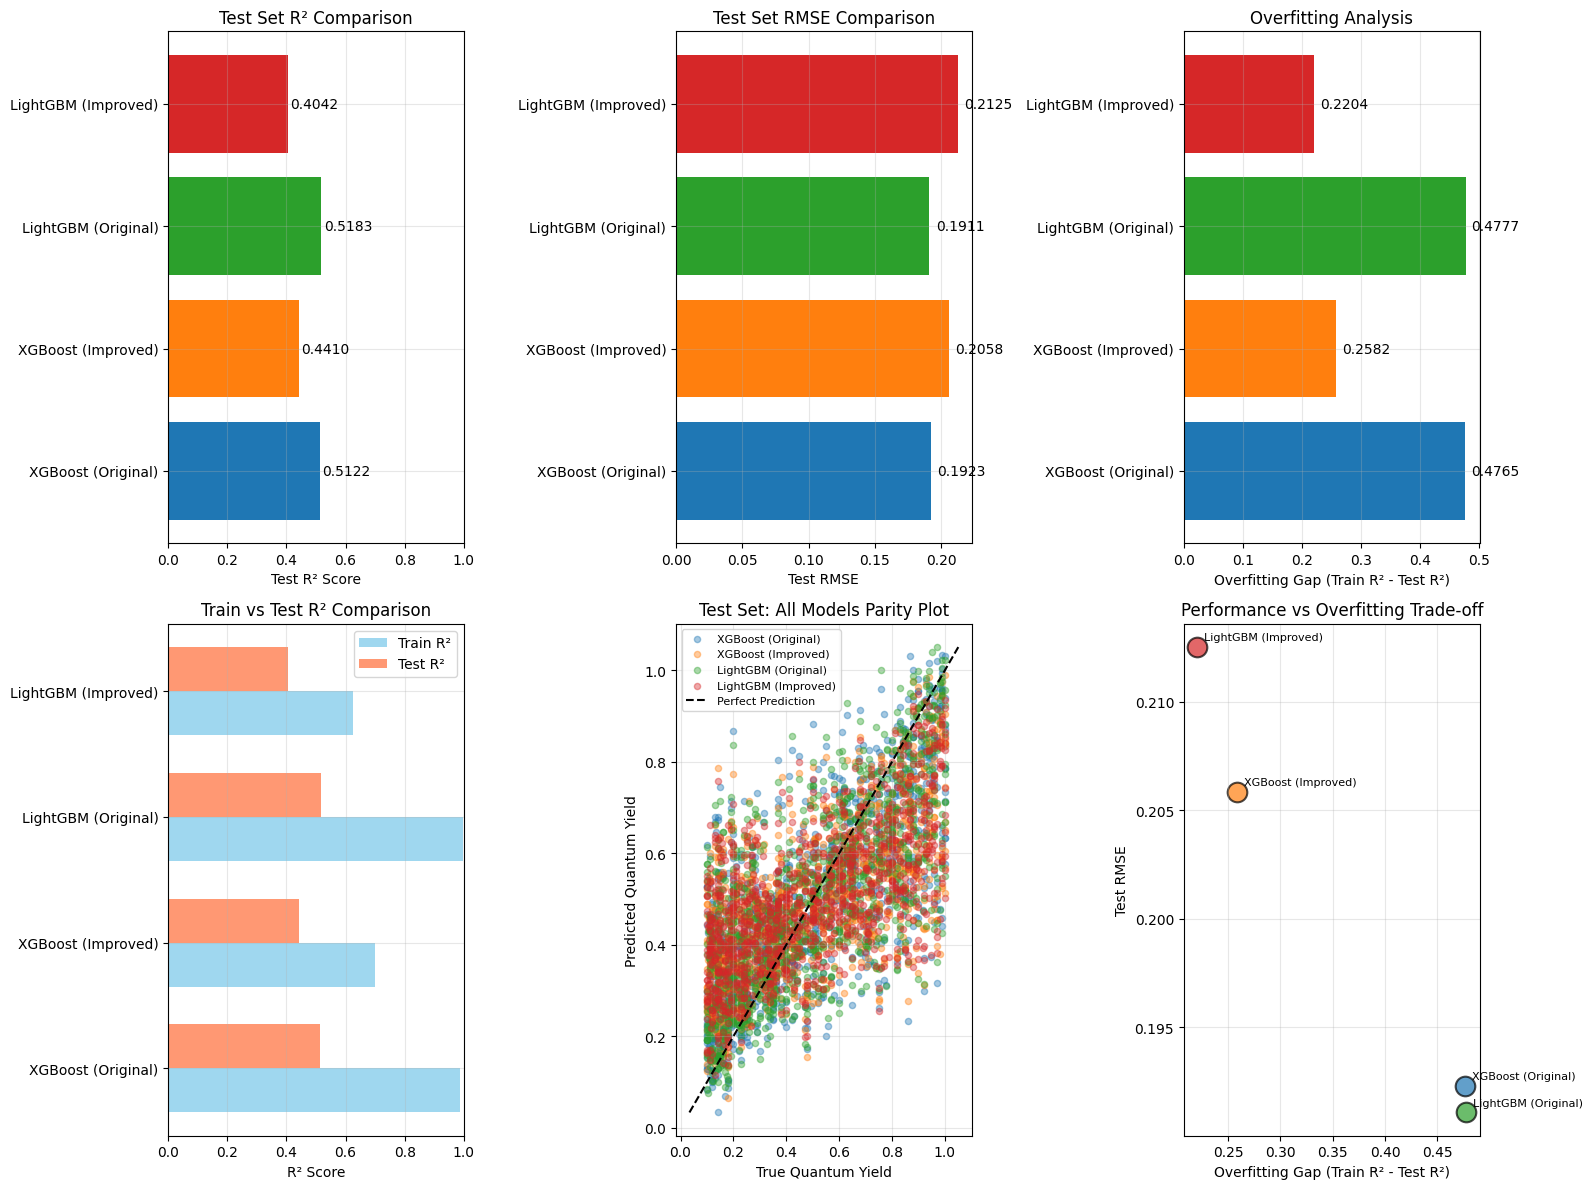


FINAL SUMMARY & RECOMMENDATIONS

🏆 Best Test Performance: LightGBM (Original)
   Test R²: 0.5183, Test RMSE: 0.1911

📊 Least Overfitting: LightGBM (Improved)
   Overfitting Gap: 0.2204

💡 Recommendation:
   For best predictions: Use LightGBM (Original) (Test R²: 0.5183)
   For more reliable/generalizable model: Use LightGBM (Improved) (Gap: 0.2204)



In [27]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON: All 4 Models
# ============================================================================
# Compare: xgb_model (original), xgb_model_improved, lgb_model (original), lgb_model_improved

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Get predictions for all models on all sets
models = {
    'XGBoost (Original)': {
        'model': xgb_model,
        'train_pred': xgb_model.predict(X_train),
        'val_pred': xgb_model.predict(X_val),
        'test_pred': xgb_model.predict(X_test)
    },
    'XGBoost (Improved)': {
        'model': xgb_model_improved,
        'train_pred': xgb_model_improved.predict(X_train),
        'val_pred': xgb_model_improved.predict(X_val),
        'test_pred': y_pred_xgb_improved
    },
    'LightGBM (Original)': {
        'model': lgb_model,
        'train_pred': lgb_model.predict(X_train),
        'val_pred': lgb_model.predict(X_val),
        'test_pred': y_pred_lgb
    },
    'LightGBM (Improved)': {
        'model': lgb_model_improved,
        'train_pred': lgb_model_improved.predict(X_train),
        'val_pred': lgb_model_improved.predict(X_val),
        'test_pred': y_pred_lgb_improved
    }
}

# Calculate metrics for all models
results = []
for model_name, preds in models.items():
    # Train metrics
    r2_train = r2_score(y_train, preds['train_pred'])
    mae_train = mean_absolute_error(y_train, preds['train_pred'])
    rmse_train = np.sqrt(mean_squared_error(y_train, preds['train_pred']))
    
    # Validation metrics
    r2_val = r2_score(y_val, preds['val_pred'])
    mae_val = mean_absolute_error(y_val, preds['val_pred'])
    rmse_val = np.sqrt(mean_squared_error(y_val, preds['val_pred']))
    
    # Test metrics
    r2_test = r2_score(y_test, preds['test_pred'])
    mae_test = mean_absolute_error(y_test, preds['test_pred'])
    rmse_test = np.sqrt(mean_squared_error(y_test, preds['test_pred']))
    
    # Overfitting gap
    overfitting_gap = r2_train - r2_test
    
    results.append({
        'Model': model_name,
        'Train R²': r2_train,
        'Val R²': r2_val,
        'Test R²': r2_test,
        'Train RMSE': rmse_train,
        'Val RMSE': rmse_val,
        'Test RMSE': rmse_test,
        'Train MAE': mae_train,
        'Val MAE': mae_val,
        'Test MAE': mae_test,
        'Overfitting Gap': overfitting_gap
    })

# Create comprehensive comparison DataFrame
comparison_df_all = pd.DataFrame(results)

print("\n" + "-"*80)
print("ALL MODELS: COMPREHENSIVE METRICS COMPARISON")
print("-"*80)
print(comparison_df_all.to_string(index=False))

# Summary: Test Set Performance Ranking
print("\n" + "-"*80)
print("TEST SET PERFORMANCE RANKING (Best to Worst)")
print("-"*80)
test_ranking = comparison_df_all[['Model', 'Test R²', 'Test RMSE', 'Test MAE', 'Overfitting Gap']].sort_values('Test R²', ascending=False)
print(test_ranking.to_string(index=False))

# Summary: Overfitting Analysis
print("\n" + "-"*80)
print("OVERFITTING ANALYSIS (Train R² - Test R²)")
print("-"*80)
overfitting_analysis = comparison_df_all[['Model', 'Train R²', 'Test R²', 'Overfitting Gap']].sort_values('Overfitting Gap', ascending=True)
print(overfitting_analysis.to_string(index=False))

# Visualizations
fig = plt.figure(figsize=(16, 12))

# 1. Test R² Comparison
ax1 = plt.subplot(2, 3, 1)
models_list = comparison_df_all['Model'].values
test_r2 = comparison_df_all['Test R²'].values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax1.barh(models_list, test_r2, color=colors)
ax1.set_xlabel('Test R² Score')
ax1.set_title('Test Set R² Comparison')
ax1.set_xlim([0, 1])
ax1.grid(True, alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, test_r2)):
    ax1.text(val + 0.01, i, f'{val:.4f}', va='center')

# 2. Test RMSE Comparison
ax2 = plt.subplot(2, 3, 2)
test_rmse = comparison_df_all['Test RMSE'].values
bars = ax2.barh(models_list, test_rmse, color=colors)
ax2.set_xlabel('Test RMSE')
ax2.set_title('Test Set RMSE Comparison')
ax2.grid(True, alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, test_rmse)):
    ax2.text(val + 0.005, i, f'{val:.4f}', va='center')

# 3. Overfitting Gap Comparison
ax3 = plt.subplot(2, 3, 3)
overfitting_gaps = comparison_df_all['Overfitting Gap'].values
bars = ax3.barh(models_list, overfitting_gaps, color=colors)
ax3.set_xlabel('Overfitting Gap (Train R² - Test R²)')
ax3.set_title('Overfitting Analysis')
ax3.grid(True, alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, overfitting_gaps)):
    ax3.text(val + 0.01, i, f'{val:.4f}', va='center')

# 4. Train vs Test R² Comparison
ax4 = plt.subplot(2, 3, 4)
train_r2 = comparison_df_all['Train R²'].values
x_pos = np.arange(len(models_list))
width = 0.35
ax4.barh(x_pos - width/2, train_r2, width, label='Train R²', color='skyblue', alpha=0.8)
ax4.barh(x_pos + width/2, test_r2, width, label='Test R²', color='coral', alpha=0.8)
ax4.set_yticks(x_pos)
ax4.set_yticklabels(models_list)
ax4.set_xlabel('R² Score')
ax4.set_title('Train vs Test R² Comparison')
ax4.legend()
ax4.set_xlim([0, 1])
ax4.grid(True, alpha=0.3)

# 5. Test Set Predictions vs True (Parity Plots) - All models
ax5 = plt.subplot(2, 3, 5)
for i, (model_name, preds) in enumerate(models.items()):
    test_pred = preds['test_pred']
    ax5.scatter(y_test, test_pred, alpha=0.4, s=20, label=model_name, color=colors[i])
mn, mx = min(y_test.min(), min([p['test_pred'].min() for p in models.values()])), \
         max(y_test.max(), max([p['test_pred'].max() for p in models.values()]))
ax5.plot([mn, mx], [mn, mx], 'k--', lw=1.5, label='Perfect Prediction')
ax5.set_xlabel('True Quantum Yield')
ax5.set_ylabel('Predicted Quantum Yield')
ax5.set_title('Test Set: All Models Parity Plot')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Test RMSE vs Overfitting Gap Trade-off
ax6 = plt.subplot(2, 3, 6)
for i, model_name in enumerate(models_list):
    ax6.scatter(overfitting_gaps[i], test_rmse[i], s=200, color=colors[i], 
                label=model_name, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax6.annotate(model_name, (overfitting_gaps[i], test_rmse[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax6.set_xlabel('Overfitting Gap (Train R² - Test R²)')
ax6.set_ylabel('Test RMSE')
ax6.set_title('Performance vs Overfitting Trade-off')
ax6.grid(True, alpha=0.3)
# Ideal: lower overfitting gap AND lower RMSE (bottom-left is best)

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)
best_test_r2_idx = comparison_df_all['Test R²'].idxmax()
best_model = comparison_df_all.loc[best_test_r2_idx, 'Model']
best_test_r2 = comparison_df_all.loc[best_test_r2_idx, 'Test R²']
best_test_rmse = comparison_df_all.loc[best_test_r2_idx, 'Test RMSE']

lowest_overfitting_idx = comparison_df_all['Overfitting Gap'].idxmin()
least_overfit_model = comparison_df_all.loc[lowest_overfitting_idx, 'Model']
least_overfit_gap = comparison_df_all.loc[lowest_overfitting_idx, 'Overfitting Gap']

print(f"\n🏆 Best Test Performance: {best_model}")
print(f"   Test R²: {best_test_r2:.4f}, Test RMSE: {best_test_rmse:.4f}")

print(f"\n📊 Least Overfitting: {least_overfit_model}")
print(f"   Overfitting Gap: {least_overfit_gap:.4f}")

print(f"\n💡 Recommendation:")
if best_model == least_overfit_model:
    print(f"   {best_model} is the best overall choice (best performance + least overfitting)")
else:
    print(f"   For best predictions: Use {best_model} (Test R²: {best_test_r2:.4f})")
    print(f"   For more reliable/generalizable model: Use {least_overfit_model} (Gap: {least_overfit_gap:.4f})")
    
print("\n" + "="*80)
